# 230815 - Property Equity Ratio Analysis

저번 노트북에서 부동산자산비율의 treatment 값이 유의미하게 낮은 p값을 보이는 것을 확인했다. 이에 대한 한 층 더 나아간 연구를 할 예정이다. 

아래와 같은 세가지 코드를 실행할 예정이다:

1. 나이에 따른 부동산자산비중의 분포를 확인한다. 구체적인 사항은 아래와 같다:
    - X는 나이, RES_AGE이다
    - Y는 부동산자산비중, property_equity_ratio이다. 
    - 아래와 같은 변수통제를 실시한다:
        - 지역은 서울로만 통제한다. 
        - 학력은 대졸, 고졸, 두 그룹으로 나눈다. 
        - 소득은 4분위로 나눠 네개의 그룹으로 나눈다. 
    - 우리는 총 2 x 4 = 8개의 선을 보게 된다.
    - 97년 당시 50세, 60세인 그룹에 수직인 선을 긋는다. 
    
이는 변수를 통제했을 때 연령에 따른 부동산자산비중을 확인을 하기 위함이다. 

    
2. 종전에는 40-49, 50-59, 60-69 총 세 그룹으로 쪼개서 다중선형회귀를 돌려보았다. 이제는 5년 단위로 쪼개서 똑같이 linear regression을 그려본다.

이는 10년 단위로 쪼갰을 때 나온 패턴이 5년 단위로 쪼갰을 때도 동일하게 나오는지를 확인하기 위한 robustness check 절차이다.

3. Interaction term을 추가하여 linear regression을 다시 그려본다. 
    - RES_SEX * treatments
    - RES_EDU1 * treatments
    
이는 treatment effect의 성별과 교육수준에 대한 이질성을 파악하기 위함이다.  
    

In [1]:
# Data Manipulation Libraries
import numpy as np
import pandas as pd
from scipy import stats
import pyreadstat

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing Libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

# Machine Learning Libraries
from xgboost import XGBRegressor, XGBClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score

# Econometrics Libraries
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV
import statsmodels.api as sm
from scipy.stats import norm

# Explainability Libraries
import shap

# Model Storage Libraries
import joblib

# Optional: Uncomment if you need to install xgboost within the notebook
# !pip install xgboost

In [2]:
csv_file_path = '2020_survey_data_cleansed.csv'
df = pd.read_csv(csv_file_path)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# 1. 나이에 따른 부동산자산분포 확인 (변수통제)

나이에 따른 부동산자산비중의 분포를 확인한다. 구체적인 사항은 아래와 같다:
  - X는 나이, RES_AGE이다
  - Y는 부동산자산비중, property_equity_ratio이다. 
  - 아래와 같은 변수통제를 실시한다:
      - 지역은 서울로만 통제한다. 
      - 학력은 대졸, 고졸, 두 그룹으로 나눈다. 
      - 소득은 4분위로 나눠 네개의 그룹으로 나눈다. 
  - 우리는 총 2 x 4 = 8개의 선을 보게 된다.
  - 97년 당시 50세, 60세인 그룹에 수직인 선을 긋는다. 
    
    
대한민국의 관리체제 기간은 1997년 12월 3일부터 2001년 8월 23일까지 약 3년 8개월이었다.

97년 당시 50세는 2020년 기준 73세, 97년 기준 60세는 2020년 기준 83세이다. 



## 1.1 AREA 변수 더미처리

In [4]:
AREAs = [11,21,22,23,24,25,26,29,31,32,33,34,35,36,37,38,39]
# 지역 값 바꿔주기
df['AREA'] = df['AREA'].replace({11:"Seoul", 21:"Busan", 22:"Daegu", 23:"Incheon", 24:"Gwangju", 25:"Daejeon", 
         26:"Ulsan", 29:"Sejong", 31:"Gyeonggi", 32:"Gangwon",
        33:"Chungbuk", 34:"Chungnam",35:"Jeonbuk",36:"Jeonnam",
        37:"Gyeongbuk",38:"Gyeongnam", 39:"Jeju"})
# AREA에 대한 one-hot encoding
AREA_dummies = pd.get_dummies(df['AREA'], prefix='AREA')

# Concantenate
df = pd.concat([df, AREA_dummies], axis=1)

## 1.2 AREA별 데이터 갯수 살펴보기

In [5]:
# Get the values of AREA and their counts in descending order
area_counts = df['AREA'].value_counts()

# Print the sorted values and counts
for area, count in area_counts.items():
    print(f"{area}: {count}")

Gyeonggi: 1156
Seoul: 1015
Busan: 702
Gyeongnam: 664
Gyeongbuk: 647
Jeonnam: 597
Daegu: 553
Jeonbuk: 546
Chungnam: 545
Incheon: 520
Gangwon: 476
Chungbuk: 467
Daejeon: 419
Gwangju: 409
Ulsan: 385
Jeju: 366
Sejong: 196


경기가 1156개로 가장 많고, 서울이 1015개로 그 다음으로 많다. 우리는 변수 통제를 위해 서울의 데이터만을 취한다. 

## 1.3 서울거주자의 소득 분포

서울거주자 약 1000명을 뽑았다. 그 후 소득의 4분위로 나누어보려고 했다. 하지만 아래와 같이 샘플의 절반 이상이 소득이 없다.

In [6]:
# Filter by AREA_Seoul
seoul_df = df[df['AREA_Seoul'] == 1]

In [7]:
seoul_df['J3b_1_1'].describe()

count    1015.000000
mean      536.746798
std       972.615662
min         0.000000
25%         0.000000
50%         0.000000
75%       720.000000
max      6200.000000
Name: J3b_1_1, dtype: float64

아래와 같이 샘플의 절반 이상이 소득이 없는 관계로 4분위보다는 소득 유/무 두 그룹으로 나눈다. 그런 경우 분포는 아래와 같다. 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


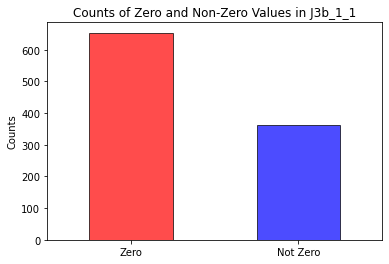

In [8]:
# Creating 'is_zero' column
seoul_df['is_zero'] = seoul_df['J3b_1_1'] == 0

# Getting counts
counts = seoul_df['is_zero'].value_counts().rename({True: 'Zero', False: 'Not Zero'})

# Plotting
counts.plot(kind='bar', color=['red', 'blue'], edgecolor='k', alpha=0.7)
plt.ylabel('Counts')
plt.title('Counts of Zero and Non-Zero Values in J3b_1_1')
plt.xticks(rotation=0)
plt.show()

## 1.4 서울거주자의 소득 유/무 두 그룹의 나이에 따른 부동산자산비중 변화

소득있음/없음 이 두 그룹으로 나눈 후 부동산자산비중의 변화추이를 살펴보았다. 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


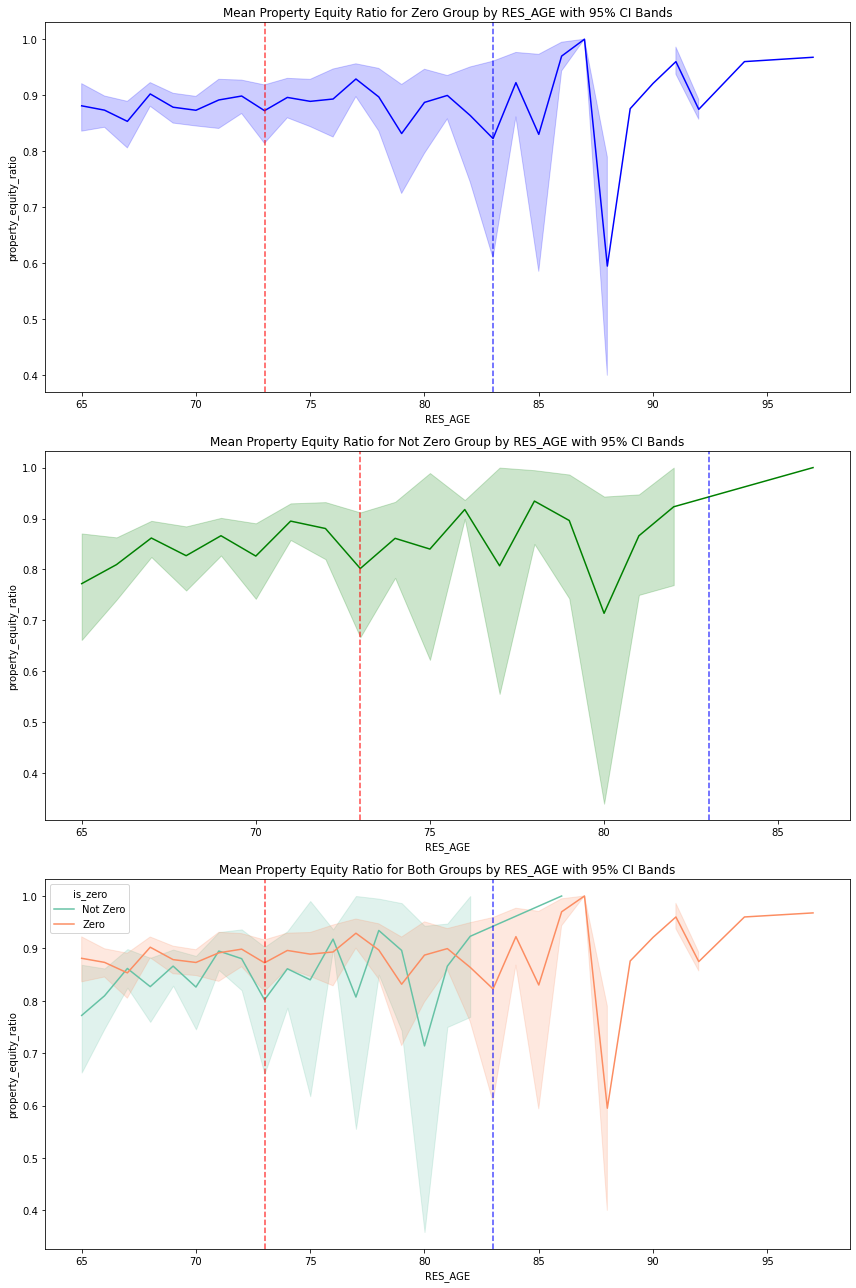

In [9]:
seoul_df['is_zero'] = seoul_df['J3b_1_1'].apply(lambda x: 'Zero' if x == 0 else 'Not Zero')

fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plotting for the Zero group
sns.lineplot(data=seoul_df[seoul_df['is_zero'] == 'Zero'], x='RES_AGE', y='property_equity_ratio', ci=95, ax=axes[0], color='blue')
axes[0].axvline(x=73, color='red', linestyle='--', alpha=0.7)
axes[0].axvline(x=83, color='blue', linestyle='--', alpha=0.7)
axes[0].set_title('Mean Property Equity Ratio for Zero Group by RES_AGE with 95% CI Bands')

# Plotting for the Not Zero group
sns.lineplot(data=seoul_df[seoul_df['is_zero'] == 'Not Zero'], x='RES_AGE', y='property_equity_ratio', ci=95, ax=axes[1], color='green')
axes[1].axvline(x=73, color='red', linestyle='--', alpha=0.7)
axes[1].axvline(x=83, color='blue', linestyle='--', alpha=0.7)
axes[1].set_title('Mean Property Equity Ratio for Not Zero Group by RES_AGE with 95% CI Bands')

# Plotting for both groups
sns.lineplot(data=seoul_df, x='RES_AGE', y='property_equity_ratio', hue='is_zero', ci=95, ax=axes[2], palette="Set2")
axes[2].axvline(x=73, color='red', linestyle='--', alpha=0.7)
axes[2].axvline(x=83, color='blue', linestyle='--', alpha=0.7)
axes[2].set_title('Mean Property Equity Ratio for Both Groups by RES_AGE with 95% CI Bands')

plt.tight_layout()
plt.show()

서울지역 노인의- 소득보유자와 소득미보유자 그룹의 - 연령별 평균 부동산자산비중의 그림이다.

샘플수가 워낙 적어서인지 뚜렷한 추이가 보이지 않는다. 600명에 30개의 구간이면, 각 연령마다 샘플수가 평균 20 밖에 안 된다. 그리고 전기 노인의 비중이 높아 negative skewness를 고려하면 나이가 많을수록 샘플의 정확도는 더더욱 떨어진다. 

그래서 이번에는 지역에 대한 필터링을 제외하고, 소득과 교육수준을 통제해본다. 

## 1.5 소득과 교육수준 통제 후 나이에 따른 변화비중살펴보기

In [10]:
df['J3b_1_1'].describe()

count     9663.000000
mean       352.479147
std        911.707505
min          0.000000
25%          0.000000
50%          0.000000
75%         81.000000
max      15000.000000
Name: J3b_1_1, dtype: float64

### 일단 교육수준에 대한 통제는 제외하고 소득 유/무 두 그룹의 나이에 따른 부동산자산비중을 변화추이를 살펴보았다

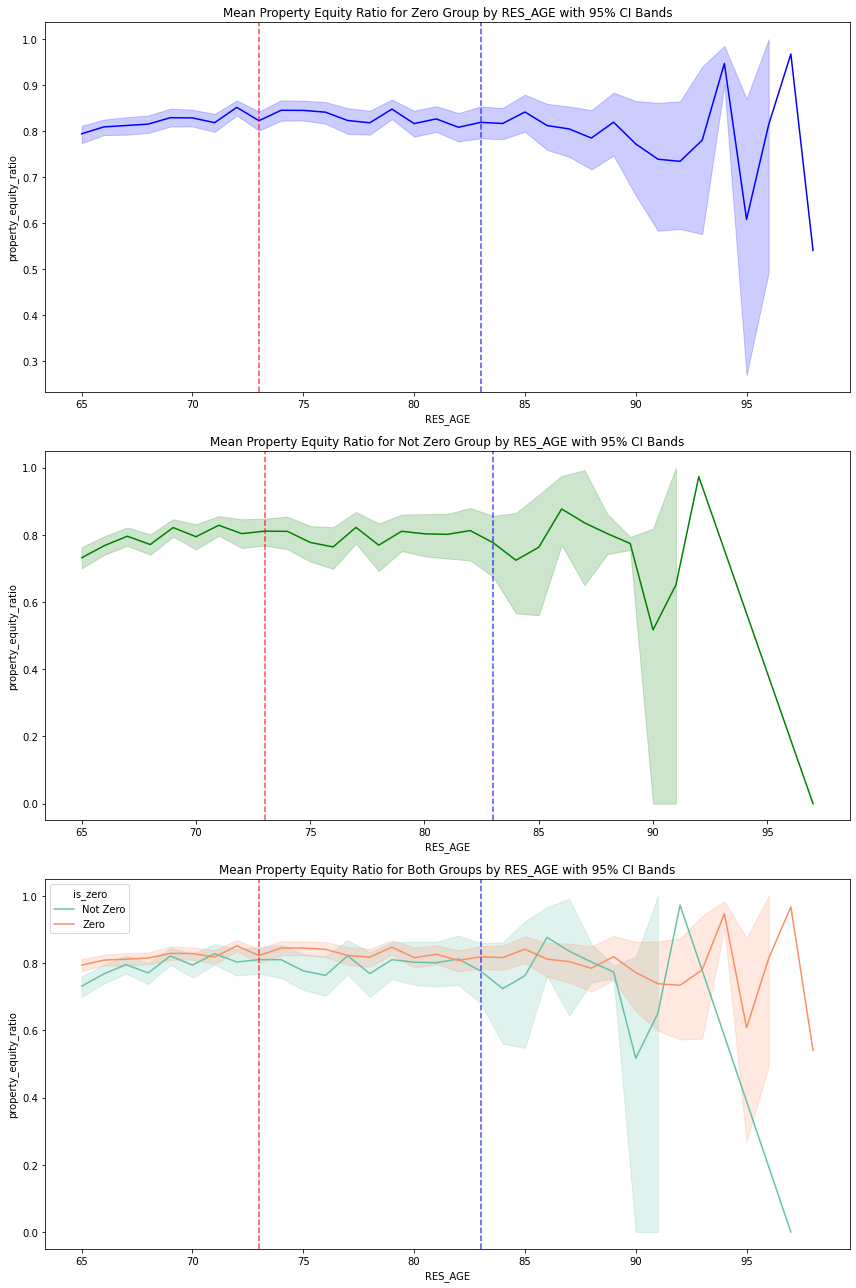

In [11]:
df['is_zero'] = df['J3b_1_1'].apply(lambda x: 'Zero' if x == 0 else 'Not Zero')

fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plotting for the Zero group
sns.lineplot(data=df[df['is_zero'] == 'Zero'], x='RES_AGE', y='property_equity_ratio', ci=95, ax=axes[0], color='blue')
axes[0].axvline(x=73, color='red', linestyle='--', alpha=0.7)
axes[0].axvline(x=83, color='blue', linestyle='--', alpha=0.7)
axes[0].set_title('Mean Property Equity Ratio for Zero Group by RES_AGE with 95% CI Bands')

# Plotting for the Not Zero group
sns.lineplot(data=df[df['is_zero'] == 'Not Zero'], x='RES_AGE', y='property_equity_ratio', ci=95, ax=axes[1], color='green')
axes[1].axvline(x=73, color='red', linestyle='--', alpha=0.7)
axes[1].axvline(x=83, color='blue', linestyle='--', alpha=0.7)
axes[1].set_title('Mean Property Equity Ratio for Not Zero Group by RES_AGE with 95% CI Bands')

# Plotting for both groups
sns.lineplot(data=df, x='RES_AGE', y='property_equity_ratio', hue='is_zero', ci=95, ax=axes[2], palette="Set2")
axes[2].axvline(x=73, color='red', linestyle='--', alpha=0.7)
axes[2].axvline(x=83, color='blue', linestyle='--', alpha=0.7)
axes[2].set_title('Mean Property Equity Ratio for Both Groups by RES_AGE with 95% CI Bands')

plt.tight_layout()
plt.show()

### 그 다음 교육수준까지 마저 통제하고 살펴보았다. 
- 0	미취학(만 10세 이하의 미취학자)
- 1	무학(글자 모름)
- 2	무학(글자 해독)
- 3	초등학교
- 4	중학교
- 5	고등학교
- 6	대학(4년 미만)
- 7	대학교 이상

In [12]:
edu_counts = df['RES_EDU1'].value_counts(ascending=True)
print(edu_counts)

6     198
1     294
7     301
2     758
4    2299
5    2625
3    3188
Name: RES_EDU1, dtype: int64


초졸 -> 중졸 -> 고졸 순으로 숫자가 떨어진다. 이렇게 세집단으로 나눈 후 그려봤다.


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


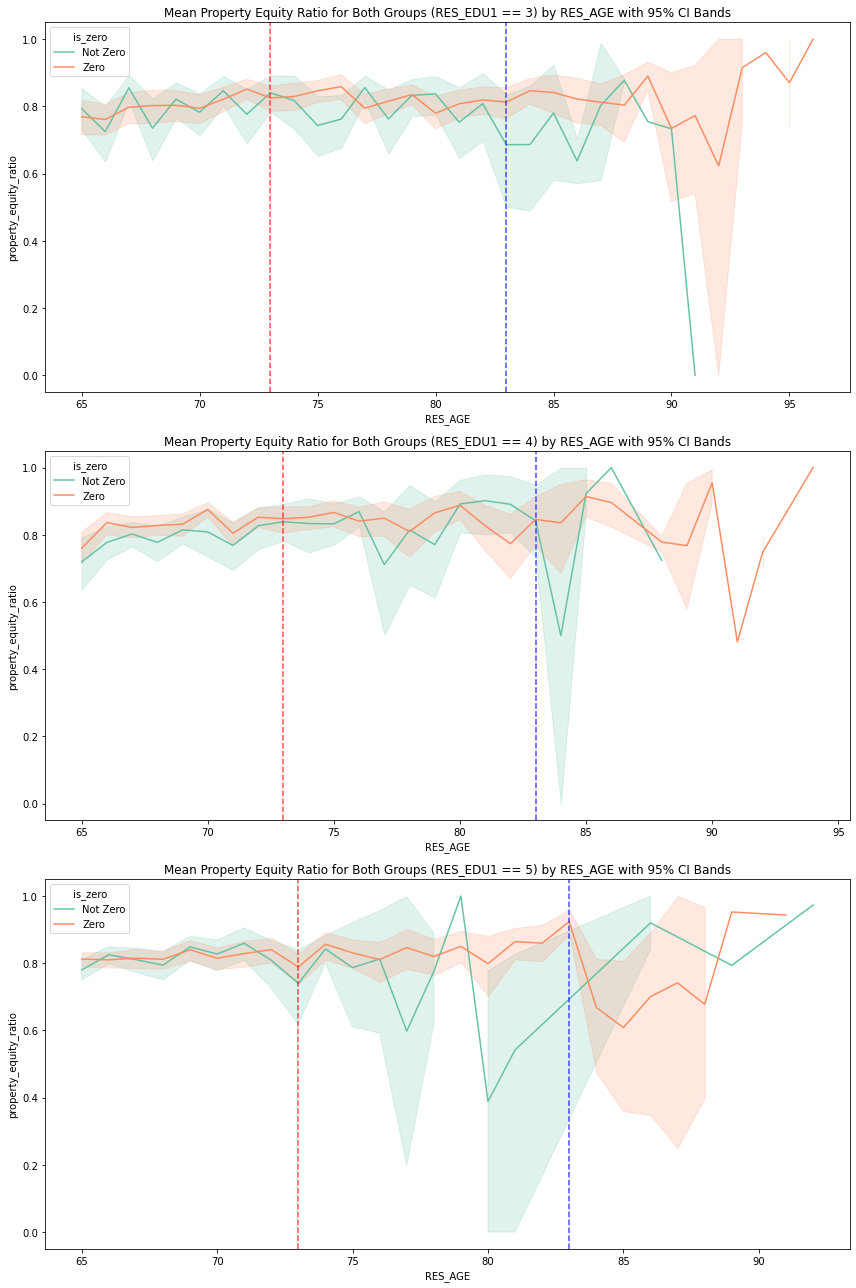

In [13]:
values_to_plot = [3, 4, 5]
fig, axes = plt.subplots(len(values_to_plot), 1, figsize=(12, 6 * len(values_to_plot)))

for index, value in enumerate(values_to_plot):
    df_subset = df[df['RES_EDU1'] == value]
    df_subset['is_zero'] = df_subset['J3b_1_1'].apply(lambda x: 'Zero' if x == 0 else 'Not Zero')
    
    # Plotting for both groups
    sns.lineplot(data=df_subset, x='RES_AGE', y='property_equity_ratio', hue='is_zero', ci=95, ax=axes[index], palette="Set2")
    axes[index].axvline(x=73, color='red', linestyle='--', alpha=0.7)
    axes[index].axvline(x=83, color='blue', linestyle='--', alpha=0.7)
    axes[index].set_title(f'Mean Property Equity Ratio for Both Groups (RES_EDU1 == {value}) by RES_AGE with 95% CI Bands')

plt.tight_layout()
plt.show()

변수를 나름 통제해보았지만, 나이에 따른 부동산자산비중의 명확한 변화추이를 보진 못했다.

# 2. 5년 단위로 통제후 OLS 회귀

종전의 노트북에선 10년 단위로 treatment를 나눴다. 이번에는 5년단위로 묶어서 진행해본다.

- 첫번째 집단은 97년 당시 (관리체제 시작) 40-44세였던 집단이다. 2001년 기준 43-47세, 2020년 기준 63-67세인 집단이다 (+23). <데이터는 65세 부터 시작>
- 두번째 집단은 97년 당시 (관리체제 시작) 45-49세였던 집단이다. 2001년 기준 48-52세, 2020년 기준 68-72세인 집단이다 (+23).
- 세번째 집단은 97년 당시 (관리체제 시작) 50-54세였던 집단이다. 2001년 기준 53-57세, 2020년 기준 73-77세인 집단이다 (+23).
- 네번째 집단은 97년 당시 (관리체제 시작) 55-59세였던 집단이다. 2001년 기준 58-62세, 2020년 기준 78-82세인 집단이다 (+23).
- 다섯번째 집단은 97년 당시 (관리체제 시작) 60-64세였던 집단이다. 2001년 기준 63-67세, 2020년 기준 83-87세인 집단이다 (+23). 

데이터프레임 df에 칼럼 'treatment'를 추가한다. 여섯개 중 하나의 값을 가진다:
- 40: 40-44
- 45: 45-49
- 50: 50-54 
- 55: 55-59
- 60: 60-64
- 0: 나머지



In [14]:
conditions = [
    (df['RES_AGE'] >= 63) & (df['RES_AGE'] <= 67),
    (df['RES_AGE'] >= 68) & (df['RES_AGE'] <= 72),
    (df['RES_AGE'] >= 73) & (df['RES_AGE'] <= 77),
    (df['RES_AGE'] >= 78) & (df['RES_AGE'] <= 82),
    (df['RES_AGE'] >= 83) & (df['RES_AGE'] <= 87)
]
values = ["40","45","50","55","60"]
df['treatment'] = np.select(conditions, values, default="0")
df = df[df['treatment'] != "0"]


In [15]:
treatment_dummies = pd.get_dummies(df['treatment'], prefix='treatment')
treatment_dummies = treatment_dummies.drop(columns=['treatment_60'])

df = df.drop(columns=['AREA_Seoul'])

AREA_dummies = AREA_dummies.drop(columns=['AREA_Seoul']) 
area_columns = AREA_dummies.columns.tolist()


treatment_columns = treatment_dummies.columns.tolist()
df = pd.concat([df, treatment_dummies], axis=1)

X_columns = ['B1','RES_SEX','RES_EDU1','EDM','J3b_1_13','RES_AGE','I1x1'] + treatment_columns + area_columns
Y_options = ['property_equity_ratio','leisure_expense_ratio','B6_SUM','H16_2','H16_7']

X = df[X_columns]
X = sm.add_constant(X)

property_equity_ratio
                              OLS Regression Results                             
Dep. Variable:     property_equity_ratio   R-squared:                       0.057
Model:                               OLS   Adj. R-squared:                  0.055
Method:                    Least Squares   F-statistic:                     21.26
Date:                   Wed, 16 Aug 2023   Prob (F-statistic):          1.65e-100
Time:                           19:57:32   Log-Likelihood:                 1268.7
No. Observations:                   9436   AIC:                            -2481.
Df Residuals:                       9408   BIC:                            -2281.
Df Model:                             27                                         
Covariance Type:               nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

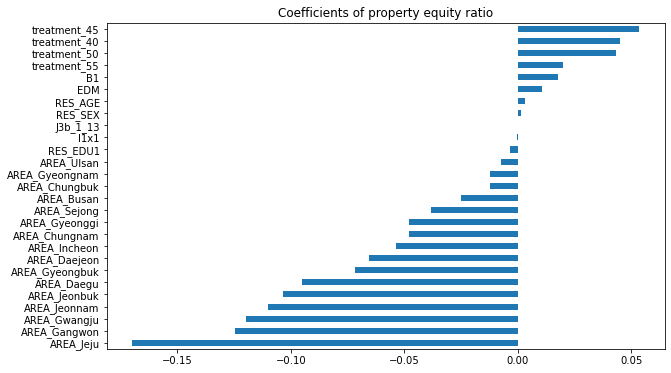

In [16]:
model = sm.OLS(df['property_equity_ratio'], X).fit()
               
print("property_equity_ratio")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Coefficients of property equity ratio")
plt.show()

| Treatment      | p value | Coefficient |
|----------------|---------|-------------|
| treatment_40   | 0.166   | 0.0449      |
| treatment_45   | 0.041   | 0.0535      |
| treatment_50   | 0.020   | 0.0432      |
| treatment_55   | 0.105   | 0.0197      |


대부분의 p값이 꽤 낮다고 볼 수 있겠다. 하지만 0.1을 초과하는 부분도 p값도 있기 때문에, 과연 robustness check가 정말 제대로 되었는지는 재확인할 추가적인 검토가 필요해보인다.

# 3. Interaction term 추가하기

Interaction term은 TE의 heterogeneity를 확인한다. 여기서 우리는 아래와 같은 두가지 interaction term을 추가한다. 
- RES_SEX와 treatment의 interaction term
- RES_EDU1와 treatment의 interaction term

In [35]:
csv_file_path = '2020_survey_data_cleansed.csv'
df = pd.read_csv(csv_file_path)

In [36]:
conditions = [
    (df['RES_AGE'] >= 63) & (df['RES_AGE'] <= 72),
    (df['RES_AGE'] >= 73) & (df['RES_AGE'] <= 82),
    (df['RES_AGE'] >= 83) & (df['RES_AGE'] <= 92)
]
values = ["forty", "fifty", "sixty"]
df['treatment'] = np.select(conditions, values, default="rest")
df = df[df['treatment'] != "rest"]

AREAs = [11,21,22,23,24,25,26,29,31,32,33,34,35,36,37,38,39]
# 지역 값 바꿔주기
df['AREA'] = df['AREA'].replace({11:"Seoul", 21:"Busan", 22:"Daegu", 23:"Incheon", 24:"Gwangju", 25:"Daejeon", 
         26:"Ulsan", 29:"Sejong", 31:"Gyeonggi", 32:"Gangwon",
        33:"Chungbuk", 34:"Chungnam",35:"Jeonbuk",36:"Jeonnam",
        37:"Gyeongbuk",38:"Gyeongnam", 39:"Jeju"})

In [37]:
# Treatment 에 대한 one-hot encoding
treatment_dummies = pd.get_dummies(df['treatment'], prefix='treatment')
treatment_dummies = treatment_dummies.drop(columns=['treatment_sixty'])

# AREA에 대한 one-hot encoding
AREA_dummies = pd.get_dummies(df['AREA'], prefix='AREA')
AREA_dummies = AREA_dummies.drop(columns=['AREA_Seoul']) 

# Concatenate
treatment_columns = treatment_dummies.columns.tolist()
area_columns = AREA_dummies.columns.tolist()
df = pd.concat([df, treatment_dummies, AREA_dummies], axis=1)

# interaction terms
df['treatment_forty*RES_SEX'] = df['treatment_forty']*df['RES_SEX']
df['treatment_fifty*RES_SEX'] = df['treatment_fifty']*df['RES_SEX']
df['treatment_forty*RES_EDU1'] = df['treatment_forty']*df['RES_EDU1']
df['treatment_fifty*RES_EDU1'] = df['treatment_fifty']*df['RES_EDU1']
interaction_columns = ['treatment_forty*RES_SEX','treatment_fifty*RES_SEX','treatment_forty*RES_EDU1','treatment_fifty*RES_EDU1']


X_columns = ['B1','RES_SEX','RES_EDU1','EDM','J3b_1_13','RES_AGE','I1x1'] + treatment_columns + area_columns + interaction_columns
Y_options = ['property_equity_ratio','leisure_expense_ratio','B6_SUM','H16_2','H16_7']

X = df[X_columns]
X = sm.add_constant(X)

property_equity_ratio
                              OLS Regression Results                             
Dep. Variable:     property_equity_ratio   R-squared:                       0.059
Model:                               OLS   Adj. R-squared:                  0.056
Method:                    Least Squares   F-statistic:                     20.57
Date:                   Wed, 16 Aug 2023   Prob (F-statistic):          1.17e-103
Time:                           22:49:06   Log-Likelihood:                 1232.0
No. Observations:                   9629   AIC:                            -2404.
Df Residuals:                       9599   BIC:                            -2189.
Df Model:                             29                                         
Covariance Type:               nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

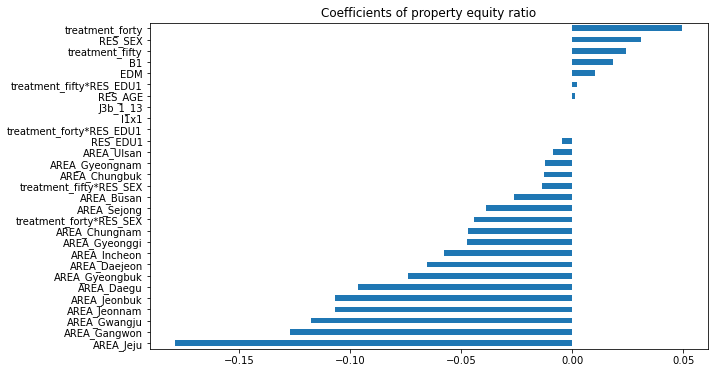

In [38]:
model = sm.OLS(df['property_equity_ratio'], X).fit()
               
print("property_equity_ratio")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Coefficients of property equity ratio")
plt.show()

- 3 : Highly significant (p < 0.01)
- 2 : Significant (0.01 ≤ p < 0.05)
- 1 : Significant (0.05 ≤ p < 0.1)
- 0 : Not significant (p ≥ 0.1)


| column name    | P-value | significance level | coefficient | explanation|
|----------------|---------|-------------|-----------------|-------------------|
| treatment_forty | 0.057  | 1                  | + 0.0496    | IMF당시 근로자의 부동산자산비중 더 높음  |
| treatment_fifty | 0.267  | 0                  | + 0.0244    | IMF당시 근로자의 부동산자산비중 더 높음  |
|- |- |- |- |- |
| treatment_forty x RES_SEX | 0.010  | 2      | - 0.0444    | 남성에게 주어지는 forty의 TE가 더 낮음  |
| treatment_fifty x RES_SEX | 0.439  | 0      | - 0.0138    | 남성에게 주어지는 fifty의 TE가 더 낮음  |
| treatment_forty x RES_EDU1 | 0.965 | 0      | - 0.0003    | 교육수준이 높을수록 forty의 TE가 더 낮음  |
| treatment_fifty x RES_EDU1 | 0.738 | 0      | + 0.0024   | 교육수준이 높을수록 fifty의 TE가 더 높음  |
|- |- |- |- |- |
| B1(건강나쁜정도)   | 0.000  | 3                   | + 0.0182   | 건강이 안 좋을수록 부동산자산비중 높음 |
| RES_SEX         | 0.051  | 1                  |  + 0.0312  |남성의 부동산자산비중 높음|
| EDM             | 0.089  | 1                  |  + 0.0105   | 동에 있을수록 부동산자산비중 더 높음 |
| J3b_1_13        |  0.000 | 3                  | - 5.173e-06   | 소득이 높을수록 부동산자산비중 더 낮음 |
| AREA            |  대체로 낮음 | 대체로 높음         |  마이너스 값   | 非서울이 부동산자산비중 더 낮음 |
|- |- |- |- |- |
| RES_EDU1        | 0.449  | 0                  |  - 0.0048   | 교육수준 높을수록 부동산자산비중 더 낮음 |
| I1x1            |  0.699 | 0                  |  - 0.0002   | 인지기능이 높을수록 부동산자산비중 더 낮음 |
| RES_AGE         |  0.163 | 0                  |  + 0.0496   | 나이가 많을수록 부동산자산비중 더 낮음 |

Interaction을 추가하지 않고 넣었을 때 다중회귀분석의 결과는 다음과 같았다:

| column name    | P-value | significance level | coefficient | explanation|
|----------------|---------|-------------|-----------------|-------------------|
| treatment_forty | 0.092  | 1                  | + 0.0286    | IMF당시 근로자의 부동산자산비중 더 높음  |
| treatment_fifty | 0.009  | 3                  | + 0.0277    | IMF당시 근로자의 부동산자산비중 더 높음  |
|- |- |- |- |- |
| B1(건강나쁜정도)   | 0.000  | 3                   | + 0.0181   | 건강이 안 좋을수록 부동산자산비중 높음 |
| EDM             | 0.092  | 1                  |  + 0.0104   | 동에 있을수록 부동산자산비중 더 높음 |
| J3b_1_13        |  0.000 | 3                  | - 5.454e-06   | 소득이 높을수록 부동산자산비중 더 낮음 |
| AREA            |  대체로 낮음 | 대체로 높음         |  마이너스 값   | 非서울이 부동산자산비중 더 낮음 |
|- |- |- |- |- |
| RES_SEX         | 0.640  | 0                  |  + 0.0022  |남성의 부동산자산비중 높음|
| RES_EDU1        | 0.131  | 0                  |  - 0.0034  | 교육수준 높을수록 부동산자산비중 더 낮음 |
| I1x1            |  0.699 | 0                  |  - 0.0002   | 인지기능이 높을수록 부동산자산비중 더 낮음 |
| RES_AGE         |  0.208 | 0                  |  - 0.0011   | 나이가 많을수록 부동산자산비중 더 낮음 |

#### - Interaction terms 를 추가하고 아래와 같은 변화들이 생겼다:
- treatment_fifty의 p값이 급격히 올랐다. (0.009 -> 0.267) 
- interaction terms중 treatment_forty x RES_SEX 제외 p값이 유의미하게 낮은 항목이 없다. 
- interaction terms중 유일하게 p값이 유의미하게 낮은 treatment_forty x RES_SEX는 음수이다. 남성의 TE가 더 낮음을 의미한다. 우리의 가정과 상충이 된다. 
- 성별의 p값이 유의미한 수준으로 낮아졌다. (0.640 -> 0.051) 